In [135]:
import numpy as np
import pandas as pd
from copy import deepcopy
import json
#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer #use this to create BoW matrix
import pyLDAvis.sklearn # a specialized package for topic model visualization

#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [136]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')
    new_words = ['u','ur',',','https',"'","i'm",'like','lol','get','one','http',
                "reeee","bro","need","tbh","ppl","wow","dude","ye","okay","ik","ep",
                 "ya","plz","need","look","idk","c",'b','imo','smh','haha',"n't",
                '.first','wtf','ta','im',"’"]
    stop_words = stop_words + (new_words)
    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return tweet_norm


In [137]:
# Opening JSON file
filepath = 'channel_messages.json'
f = open(filepath)

# returns JSON object as 
# a dictionary
data = json.load(f)
message = []
# Iterating through the json
# list
for i in data:
    try:
        if i['media'] == None:
            message.append(i['message'])
    except:pass
# Closing file
f.close()

In [138]:
message

['OOF, poorly scheduled messages',
 'https://t.me/c/1179447288/67840',
 'As an iPhone user this cannot stand',
 'AMC has a vip line for snacks',
 'Omrahn do it for the memes',
 'No he’s not',
 'He’s practically your idol at this point',
 'Do it',
 'John time to brainstorm',
 'I feel we would have to get something no one ever got before to do that',
 'U guys should try to get on the tik tok',
 'I’m down',
 'Ockywaysuresure.gif',
 "Don't ignore me Omrahn",
 "And anyone else who's interested :)",
 'I will, no joke, plan a day trip with u next month to go to the ocky store if ur willing',
 'Omrahn',
 'Holy fuck, jamshid and hassib heavy as fuck',
 'Simple joke, simple meme',
 'Omrahn brings 3 friends to play fifa',
 'Holy shit',
 'Why am I confused',
 'There was no joke',
 'I just thought it was funny',
 'Then what was the point of sending that',
 'Ur not banned from fifa u weirdo',
 'I just thought it was funny',
 'There is no hypocrisy there u crazy man',
 'I wanna see the full hypocrisy

In [139]:
messagess = pd.DataFrame(message,columns = ['text'])
messages = messagess.copy(deep=True)

In [140]:
messages['text'] = messages['text'].apply(process_tweet, args = [5])

In [141]:
messages['text']

0         
1         
2         
3         
4         
        ..
51557     
51558     
51559     
51560     
51561     
Name: text, Length: 51562, dtype: object

In [142]:
messagess


,text
0,"OOF, poorly scheduled messages"
1,https://t.me/c/1179447288/67840
2,As an iPhone user this cannot stand
3,AMC has a vip line for snacks
4,Omrahn do it for the memes
...,...
51557,Jamshid watching that last game
51558,i missed the last game
51559,That last game
51560,Did it work?


In [143]:
messages_new = messages[messages['text'] != '']

In [144]:
corpus = messages_new['text']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<5925x6588 sparse matrix of type '<class 'numpy.float64'>'
	with 44130 stored elements in Compressed Sparse Row format>

In [145]:
len(vectorizer.get_feature_names())

6588

In [146]:
topic_model = NMF(n_components = 5)
topic_model.fit(X_train)

NMF(n_components=5)

In [147]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (5, 6588)
Shape of H is (5925, 5)
Shape of X_train is (5925, 6588)


In [148]:
W[4]

array([0.        , 0.        , 0.        , ..., 0.00018469, 0.00019643,
       0.00019643])

In [149]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['everyone', 'right', 'come', 'man', 'even', 'take', 'bad', 'cause', 'gon', 'work', 'thing', 'people', 'see', 'back', 'want', 'know', 'guy', 'shit', 'time', 'fuck', 'think', 'good', 'get', 'say', 'go']


THE TOP 10 WORDS FOR TOPIC #1
['club', 'mattee', 'first', 'know', 'well', 'start', 'next', 'time', 'night', 'offense', 'defense', 'video', 'smash', 'div', 'lose', 'want', 'gon', 'win', 'session', 'wan', 'day', 'last', 'fifa', 'game', 'play']


THE TOP 10 WORDS FOR TOPIC #2
['gregory', 'ball', 'thought', 'message', 'fuck', 'pas', 'pass', 'answer', 'offense', 'carroll', 'hassib', 'yes', 'fb', 'wisdom', 'share', 'rate', 'question', 'stimitz', 'jalil', 'john', 'omrahn', 'mattee', 'jamshid', 'greg', 'brendan']


THE TOP 10 WORDS FOR TOPIC #3
['still', 'week', 'second', 'gc', 'people', 'take', 'season', 'also', 'episode', 'aot', 'anime', 'even', 'gon', 'video', 'let', 'day', 'want', 'set', 'marvel', 'chat', 'guy', 'show', 'movie', 'group', 'watch']


THE TOP 10 

In [150]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

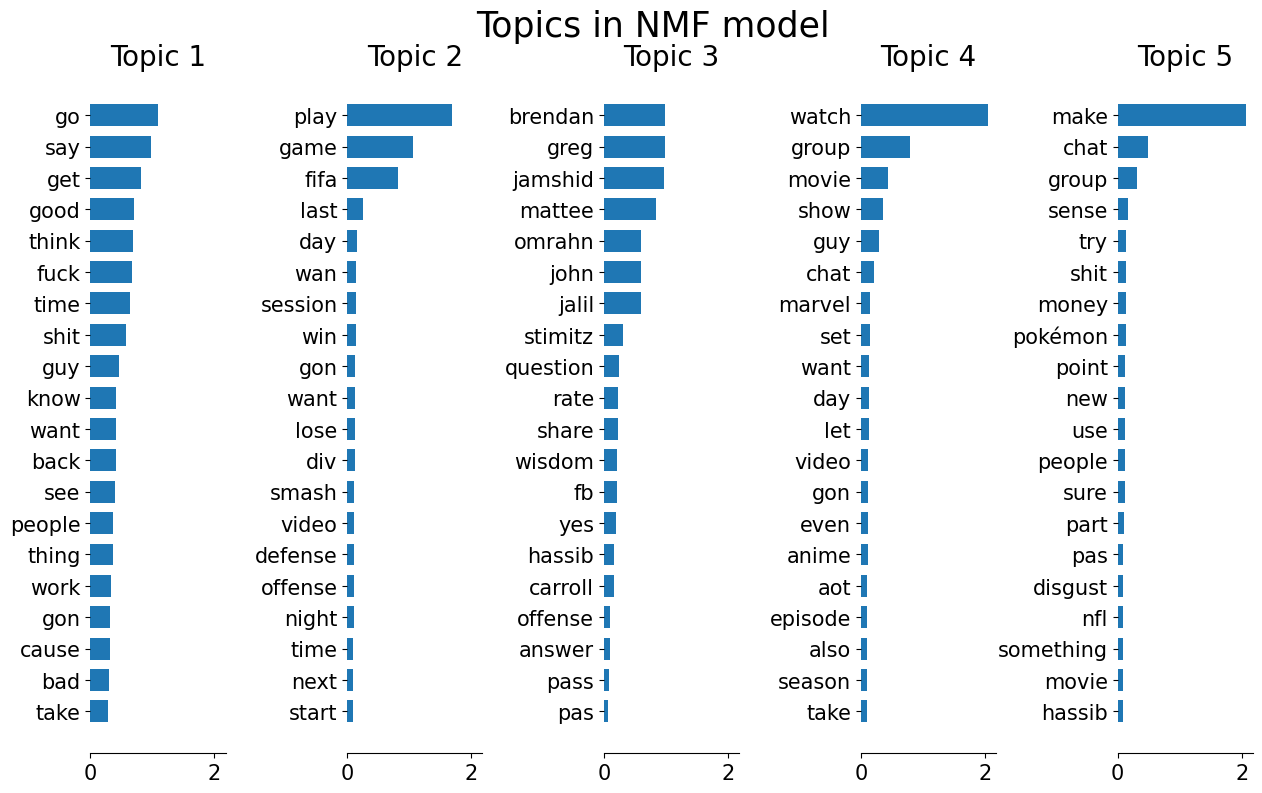

In [151]:
topic_word_plot()

In [152]:
valid_messages = messages_new.index.unique()
len(valid_messages)

5925

In [157]:
topic_name_dict = {0: 'Entertainment', 1: 'quizzarium', 
                   2: 'make_group_chat', 3: 'games', 
                   4: 'arguments'}

In [158]:
# takes in list of documents and plots topic weight vectors for each document
def tweet_topbreakdown(locator):

    #print(messagess.loc[locator].text)
    int_index = messages_new.index.get_loc(locator)

    topic_keys = topic_name_dict.values()
    zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

    topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
    topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()

    #sns.barplot(y = topic_breakdown.index, x = 'Normalized weight', data = topic_breakdown)
    #plt.title("Distribution of topics for message no. " + str(locator))
    #plt.show()

    return topic_breakdown

In [159]:
tweet_loc_list = [valid_messages[100],valid_messages[99],
                  valid_messages[390],valid_messages[750],valid_messages[900]]
#900 is hilarious
g = list(map(tweet_topbreakdown, tweet_loc_list))


In [160]:
x = dict(tweet_topbreakdown(valid_messages[100])['Normalized weight'])
list(dict(sorted(x.items(), key=lambda item: item[1],reverse = True)).keys())[0]

'games'

In [161]:
def top_topic(series):
    x = dict(series)
    x =dict(sorted(x.items(), key=lambda item: item[1]))
    return list(x.keys())[0]

In [162]:
topics = {}
topic_message = {'Entertainment':[],
                 'quizzarium':[],
                 'arguments':[],
                 'games':[],
                 'make_group_chat':[]}
for locator in valid_messages:
    int_index = messages_new.index.get_loc(locator)

    topic_keys = topic_name_dict.values()
    zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

    topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
    topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()
    x = dict(topic_breakdown['Normalized weight'])
    y = list(dict(sorted(x.items(), key=lambda item: item[1],reverse = True)).keys())[0]
    topic_message[y].append(messagess.loc[locator].text)
    if y in topics:
        topics[y] += 1
    else:
        topics[y] =1
    z = list(dict(sorted(x.items(), key=lambda item: item[1],reverse = True)).keys())[1]
    if z in topics:
        topics[z] += 0.8
    else:
        topics[z] =0.8
topics    

{'Entertainment': 4556.600000000168,
 'quizzarium': 1965.7999999999595,
 'make_group_chat': 1405.9999999999811,
 'arguments': 1428.9999999999732,
 'games': 1307.5999999999756}

In [165]:
plot = (dict(sorted(topics.items(), key=lambda item: item[1],reverse = True)))
print(plot)
plot.pop('quizzarium')
plot.pop('make_group_chat')

{'Entertainment': 4556.600000000168, 'quizzarium': 1965.7999999999595, 'arguments': 1428.9999999999732, 'make_group_chat': 1405.9999999999811, 'games': 1307.5999999999756}


1405.9999999999811

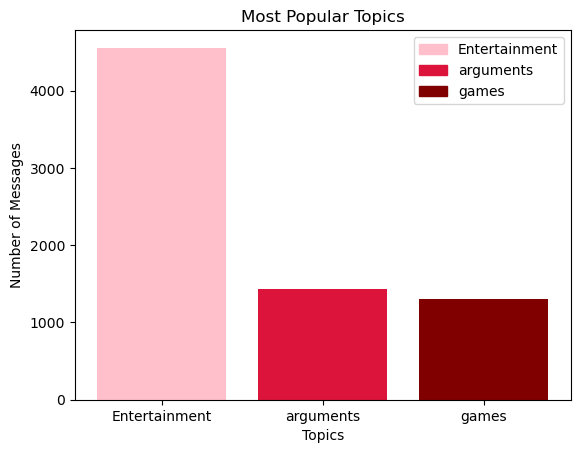

In [171]:
colors = {'Entertainment':'pink', 'arguments':'crimson','games':'maroon'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.bar(plot.keys(),plot.values(),color = colors.values())
plt.xlabel('Topics')
plt.ylabel('Number of Messages')
plt.title('Most Popular Topics')
plt.savefig('number_messages_per_topic')


In [ ]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [ ]:
# for each document takes the topic with highest weight and assigns document to this class -- hard clustering.
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of COVID-19 tweet topic segmentation')
plt.show()

In [ ]:
def lsdkfjalsdkfj():
   pass

In [ ]:
filepath = 'channel_messages.json'
f = open(filepath)

# returns JSON object as 
# a dictionary
data = json.load(f)
message = []
# Iterating through the json
# list
for i in data:
    try:
        if i['media'] == None:
            message.append(i['message'])
    except:pass
# Closing file
f.close()

In [173]:
# Opening JSON file
x = 'John'
filepath = 'user_data/'+ x + '/'+ x + '_messages.json'
f = open(filepath)

# returns JSON object as 
# a dictionary
data = json.load(f)
message = []
# Iterating through the json
# list
for i in data:
    try:
        if i['media'] == None:
            message.append(i['message'])
    except:pass
# Closing file
f.close()

In [175]:
data = pd.DataFrame(data)
topics = {}
topic_message = {'Entertainment':[],
                 'quizzarium':[],
                 'arguments':[],
                 'games':[],
                 'make_group_chat':[]}
for locator in message:
    topic_keys = topic_name_dict.values()
    zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

    topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
    topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()
    x = dict(topic_breakdown['Normalized weight'])
    y = list(dict(sorted(x.items(), key=lambda item: item[1],reverse = True)).keys())[0]
    topic_message[y].append(messagess.loc[locator].text)
    if y in topics:
        topics[y] += 1
    else:
        topics[y] =1
    z = list(dict(sorted(x.items(), key=lambda item: item[1],reverse = True)).keys())[1]
    if z in topics:
        topics[z] += 0.8
    else:
        topics[z] =0.8
topics    

KeyError: 'OOF, poorly scheduled messages'